In [5]:
!pip install xlrd
!pip install graphviz
!pip install pydot

    100% |████████████████████████████████| 112kB 2.2MB/s 


In [5]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import gc
import logging
import itertools
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import sys

np.random.seed(7)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
xl = pd.ExcelFile("drive/Apr.14/df_ira_gis.xlsx")
xl.sheet_names

['Sheet1']

In [0]:
data = xl.parse("Sheet1")
data = data.reset_index(drop=True)
y = data["IRA"]
data.drop(["IRA"], axis=1,inplace=True)

encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# y = np.array(y)
# data = data.as_matrix()
# data.head()

In [0]:
X_train, X_val, y_train, y_val = train_test_split(data, encoded_Y, test_size=0.25, stratify=encoded_Y, random_state=42)
dataset = {"X_train": X_train, "X_val": X_val, 
                "y_train": y_train, "y_val": y_val}

In [14]:
print(np.bincount(encoded_Y))
print(np.unique(encoded_Y))
input_dim = X_train.shape[1]
print(input_dim)

[6930 3968]
[0 1]
385


In [20]:
print("Initializing the network ...")
model = Sequential()
model.add(Dense(150, input_dim=input_dim, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(12, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(12, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Initializing the network ...


In [33]:
filepath="drive/Apr.14/model/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
class_weight_1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight_dict = {0: class_weight_1[0], 1: class_weight_1[1]*2}
print(class_weight_dict)

{0: 0.7863190302097364, 1: 2.74630376344086}


In [0]:
# model.fit(X_train, y_train, epochs=200, validation_split=0.33, batch_size=2048, callbacks=[checkpoint], class_weight=class_weight_dict, verbose=0)
model.fit(X_train, y_train, epochs=10, validation_split=0.33, batch_size=10, class_weight=class_weight_dict, verbose=1)

Train on 5475 samples, validate on 2698 samples
Epoch 1/10
5475/5475 [==============================] - 1s 250us/step - loss: 15.9840 - acc: 0.6389 - val_loss: 16.3903 - val_acc: 0.6297
Epoch 2/10
3040/5475 [===============>..............] - ETA: 0s - loss: 15.7986 - acc: 0.6431

[0]
Confusion matrix, without normalization
[[1733    0]
 [ 992    0]]
0.5


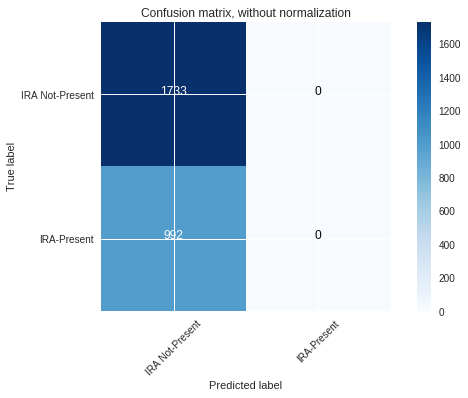

In [32]:
y_pred = model.predict_classes(dataset["X_val"])
score = roc_auc_score(dataset["y_val"], y_pred)
print(np.unique(y_pred))
# Compute confusion matrix
cnf_matrix = confusion_matrix(dataset["y_val"], y_pred)
plot_confusion_matrix(cnf_matrix, classes=["IRA Not-Present", "IRA-Present"],
                      title='Confusion matrix, without normalization')
print(score)

In [0]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("drive/Apr.14/final_model/TC_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("drive/Apr.14/final_model/TC_model.h5")
print("Saved model to disk")

In [0]:
# from keras.utils.vis_utils import plot_model
# import graphviz
# plot_model(model, to_file='drive/Apr.14/model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
np.bincount(y_train)

array([5197, 2976])